# Coursework 1

In [49]:
print("import")
import time
import os
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import scipy
import pdb
import skimage
from skimage import measure
import math

import


## Predefined functions

In [38]:
def imread(path,  is_grayscale=True):
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
  if is_grayscale:
    return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
  else:
    return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image

def preprocess(path, scale=3):
  """
  Preprocess single image file 
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  image = image / 255.
  label_ = label_ / 255.

  input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
  input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

  return input_, label_

##  1. Set the image hyper parameters

In [2]:
c_dim = 1
input_size = 255

## 2. Define the placeholders for inputs and outputs

In [3]:
inputs = tf.placeholder(tf.float32, [None, input_size, input_size, c_dim], name='inputs')

## 3. Define the model weights and biases 
Weights are the probabilities that affect how data flows in the graph

### 3.1 set the weight of three conv layers
1. conv1 layer with biases: 64 filters with size 9 x 9
2. conv2 layer with biases and relu: 32 filters with size 1 x 1
3. conv3 layer with biases and NO relu: 1 filter with size 5 x 5

In [4]:
## ------ Add your code here: set the weight of three conv layers
##   replace '0' with your hyper parameter numbers 
weights = {
#    Grayscale so only 1 channel
#   'wK': tf.Variable(tf.random_normal([Height, Width,Input(number of channels),Output (think of filters)], stddev=1e-3), name='wK'),
#    output of wK is input of wK+1. 1e-3 is  3 std deviations ie removing outliers
#    tf.random_normal A tensor of the specified shape filled with random normal values.
    'w1': tf.Variable(tf.random_normal([9, 9,1,64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1, 1,64, 32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='w3')
    }

biases = {
#     depends on filters
      'b1': tf.Variable(tf.zeros([64]), name='b1'),
      'b2': tf.Variable(tf.zeros([32]), name='b2'),
      'b3': tf.Variable(tf.zeros([1]), name='b3')
    }

In [5]:
for key in weights.keys():
    print(key, '=', weights[key])   
    print('-------------------------------------------------------------------------')   

w1 = <tf.Variable 'w1:0' shape=(9, 9, 1, 64) dtype=float32_ref>
-------------------------------------------------------------------------
w2 = <tf.Variable 'w2:0' shape=(1, 1, 64, 32) dtype=float32_ref>
-------------------------------------------------------------------------
w3 = <tf.Variable 'w3:0' shape=(5, 5, 32, 1) dtype=float32_ref>
-------------------------------------------------------------------------


## 4. Define the model layers with three convolutional layers to compute feature maps of input low-resolution images


In [6]:
# https://www.tensorflow.org/api_docs/python/tf/nn/conv2d
# conv1 layer with biases and relu : 64 filters with size 9 x 9
conv1 = tf.nn.relu(tf.nn.conv2d(inputs,weights['w1'],strides=[1,1,1,1],padding='VALID')+biases['b1'] )
## to compute non-linear mapping
# conv2 layer with biases and relu: 32 filters with size 1 x 1
conv2 = tf.nn.relu(tf.nn.conv2d(conv1,weights['w2'],strides=[1,1,1,1],padding='VALID')+biases['b2'])
## compute the reconstruction of high-resolution image
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
conv3 = tf.nn.conv2d(conv2,weights['w3'],strides=[1,1,1,1],padding='VALID') +biases['b3']


## 5. Load the pre-trained model file

In [7]:
model_path='./model/model.npy'
# model needs encoding due to error
# UnicodeError: Unpickling a python object failed: UnicodeDecodeError('ascii', b'?&\xbd\xb8\x9b\xa4%<t\xfc\x88;\xb5\xc4\x1d\xbbi\xeb\xd6\xb7\xe5\x87R\xbb\x89\xf3&\xba\xa3\xbeK;\xb6M\xa5\xb6\x12Tp\xb8sW\xe4<\xa6a7=t\xe1\x8b\xbb\x9a\x9c\xa5\xba\xd4\x1e\xa1\xba\x8daI\xba3\xf0>\xbb\t\xda\x1a\xba 4\xea\xb7j\x1ax\xb7\xef)\xeb<\x14\x1f\x94\xbbT[\x90\xba\xeb\x12\xe8=\xdc\x0c\x8b\xba\xa1\x19H\xb9\xa9\xb7\t\xbbU#\xf3\xb8\xe7\x1cL\xbcCP\xc5\xba\\\x12\xa8\xb7M\xe0\xc9\xbc', 2, 3, 'ordinal not in range(128)')
# trying ASCII encoding yields error, latin1 works
model = np.load(model_path, encoding='latin1').item()


## 6. Show the weights of model and try to visualise

In [8]:
##------ Add your code here: show the weights of model and try to visualise
# variables (w1, w2, w3)
print(weights['w1'].shape)
print(weights['w2'].shape)
print(weights['w3'].shape)

(9, 9, 1, 64)
(1, 1, 64, 32)
(5, 5, 32, 1)


In [9]:
weight_w1 = model['w1']
print (weight_w1.shape)


(9, 9, 1, 64)


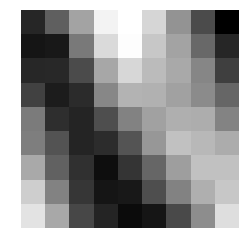

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


In [10]:
#w1 visualation (one filter)
plt.imshow(weight_w1[:,:,0,0], interpolation = None, cmap = 'gray')
plt.axis('off')
plt.show()
scipy.misc.imsave('w1_1.jpg', weight_w1[:,:,0,0])

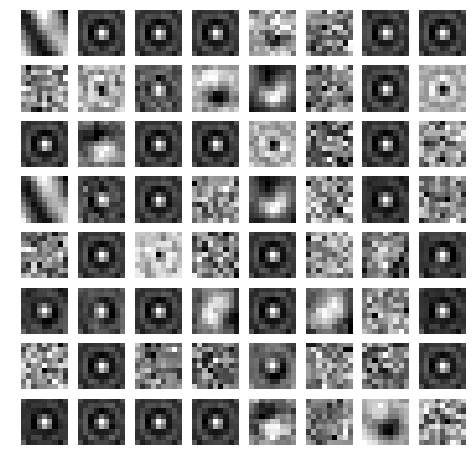

In [11]:
# weight 1 all weights
fig = plt.figure(figsize=(8,8)) #width, height in inches of the window size

for i in range(64): #number of filters
    sub = fig.add_subplot(8,8, i +1)
    sub.imshow(weight_w1[:,:,0,i], interpolation = None, cmap = 'gray')
    plt.axis('off')
plt.show()
fig.savefig('weight_1.jpg')

(1, 1, 64, 32)


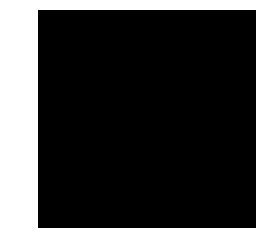

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


In [13]:
#weight 2 (1 weights)
weight_w2 = model['w2']
print (weight_w2.shape)
plt.imshow(weight_w2[:,:,0,0], interpolation = None, cmap = 'gray')
plt.axis('off')
plt.show()
scipy.misc.imsave('w2_2.jpg', weight_w2[:,:,0,0])

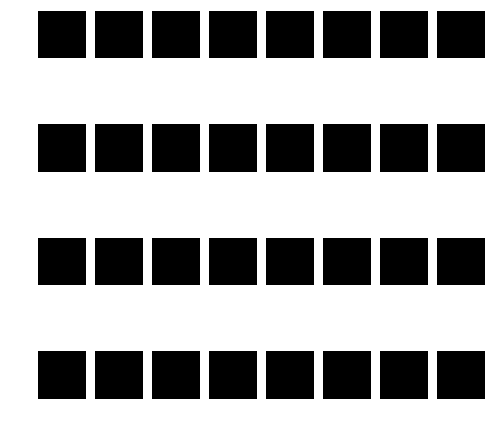

In [14]:
# weight 2 all weights
fig = plt.figure(figsize=(8,8)) #width, height in inches of the window size

for i in range(32): #number of filters
    sub = fig.add_subplot(4,8, i +1)
    sub.imshow(weight_w2[:,:,0,i], interpolation = None, cmap = 'gray')
    plt.axis('off')
plt.show()
fig.savefig('weight_2.jpg')

In [15]:
weight_w3 = model['w3']
print (weight_w3.shape)

(5, 5, 32, 1)


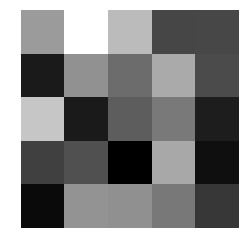

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


In [16]:
# wegiht 3 all weights
plt.imshow(weight_w3[:,:,0,0], interpolation = None, cmap = 'gray')
plt.axis('off')
plt.show()
scipy.misc.imsave('weight_3.jpg', weight_w3[:,:,0,0])

1. To read the image named butterfly_GT.bmp
2. To show the size of this image
3. To convert the image from the RGB colour space into the gray-scale space
(Tip: use scipy package to read image, set a breakpoint to watch the image
values, import pdb, pdb.set_trace())
4. To shrink the current image by 3 times with bicubic interpolation algorithm
(Tip: imresize is a Tensorflow build-in function)
5. To enlarge the current image by 3 times with bicubic interpolation algorithm

In [39]:
butterfly_path = './image/butterfly_GT.bmp'

In [40]:
preprocess(butterfly_path, scale=3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


(array([[0.25920766, 0.25513822, 0.24947969, ..., 0.22881679, 0.23044209,
         0.2311485 ],
        [0.27887741, 0.27002362, 0.25395327, ..., 0.22590221, 0.22799059,
         0.22887226],
        [0.31383543, 0.29562754, 0.25912508, ..., 0.21665222, 0.21967467,
         0.22091369],
        ...,
        [0.2154972 , 0.2194135 , 0.2315378 , ..., 0.43357426, 0.43390126,
         0.43403882],
        [0.21987673, 0.22691946, 0.24443674, ..., 0.43563727, 0.43621522,
         0.43647703],
        [0.22228927, 0.2306639 , 0.25035676, ..., 0.43643971, 0.43717625,
         0.43751569]]),
 array([[0.12304706, 0.17582353, 0.26438431, ..., 0.24218823, 0.2461098 ,
         0.2343451 ],
        [0.10359216, 0.12516471, 0.15560001, ..., 0.22901568, 0.23293725,
         0.23775294],
        [0.25316862, 0.13490589, 0.10892157, ..., 0.23798824, 0.2419098 ,
         0.24583137],
        ...,
        [0.19275686, 0.20656471, 0.1734902 , ..., 0.43803136, 0.42969803,
         0.44169805],
        [0.1

In [25]:


# def reshape_model(model,weights, key):
#     return model[key].reshape(weights[key].shape)

# def display(image, dimension=2):
#     """"""
#     # height, width, number of channels, reshape using numpy
#     # visualise the model loaded
 
#     for i in range(image.shape[dimension]):
#     #     subplot
#         plt.imshow(image[:,:,i]) 
#     return image 


In [26]:
# v1= reshape_model(model, weights, 'w1')
# v2 =reshape_model(model, weights, 'w2')
# v3 =reshape_model(model, weights, 'w3')

In [27]:
# # height, width, number of channels, reshape using numpy
# # visualise the model loaded
# v1=model['w1'].reshape(9,9,64)
# # v1 is 3 dimension, take all of 1st dimension, all of 2nd dimension
# for i in range(v1.shape[2]):
# #     subplot
#     image =v1[:,:,i]
#     image.squeeze()
#     plt.imshow(image) 

In [41]:
def main(model,weights, biases, image_path,feature_map):
    """Initialize the model variables (w1, w2, w3, b1, b2, b3) with the pre-trained model file
    """
    # launch a session
    sess = tf.Session()

    for key in weights.keys():
      sess.run(weights[key].assign(model[key]))

    for key in biases.keys():
      sess.run(biases[key].assign(model[key]))

    """Read the test image
    """
    blurred_image, groundtruth_image = preprocess(butterfly_path)

    """Run the model and get the SR image
    """
    # transform the input to 4-D tensor
    input_ = np.expand_dims(np.expand_dims(blurred_image, axis =0), axis=-1)
    # run the session
    # here you can also run to get feature map like 'conv1' and 'conv2' 
#     paper suggests 'conv3'
    output_ = sess.run(feature_map, feed_dict={inputs: input_})
    return (blurred_image,groundtruth_image,input_,output_)

In [42]:
(blurred_image,groundtruth_image,input_,output_)= main(model,weights, biases, butterfly_path,conv3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [59]:

##------ Add your code here: save the blurred and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.meause.compare_psnr()'
# imsave is deprecated! imsave is deprecated in SciPy 1.0.0, and will be removed in 1.2.0. Use imageio.imwrite instea
scipy.misc.imsave('blurred.jpg',blurred_image)
scipy.misc.imsave('groundtruth.jpg', groundtruth_image)
scipy.misc.imsave('SR.jpg', output_[0,:,:,0])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


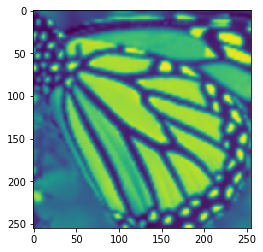

In [60]:
plt.imshow(blurred_image)

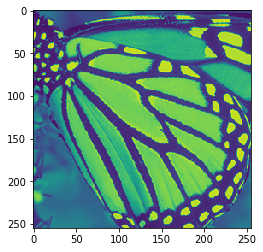

In [61]:
plt.imshow(groundtruth_image)

In [62]:
skimage.measure.compare_psnr(blurred_image[6:249,6:249],groundtruth_image[6:249,6:249])

20.453967418499577

In [63]:
skimage.measure.compare_psnr(output_[0,:,:,0].astype(np.float64) ,groundtruth_image[6:249,6:249])

21.77124830643141

In [ ]:
def compute_psnr(im1,im2):
    if im1.shape[3] == 3:
        im1 = matlab.rgb2ycbcr(im1);
        im1 = im1[:, :, 1];
    if im1.shape[3] == 3:
        im2 = matlab.rgb2ycbcr(im2);
        im2 = im2[:, :, 1];

    imdff = float(im1) - float(im2);
    imdff = imdff(:);

    rmse = math.sqrt(mean(imdff.^2))
    psnr = 10*log10(255/rmse)
    return psnr 